In [9]:
#Library Imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add
)
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import seaborn as sns

In [ ]:
#paths...
BASE = "Database"
IMAGES_PATH = os.path.join(BASE, "Image")
LABELS_PATH = os.path.join(BASE, "label.txt")


#labels...
def load_labels(labels_path):
    with open(labels_path, "r") as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 3:
            try:
                pose = float(parts[1])
                depth = float(parts[2])
                labels.append([pose, depth])
            except ValueError:
                print(f"Skipping line due to ValueError: {line}")
        else:
            print(f"Skipping line due to incorrect format: {line}")
    print(f"Loaded {len(labels)} labels.")
    return np.array(labels)


#images...
def load_images(images_path):
    image_paths = []
    images = []
    for filename in os.listdir(images_path):
        if filename.lower().endswith((".jpeg", ".jpg")):
            img_path = os.path.join(images_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224, 224))
                images.append(img_resized)
                image_paths.append(img_path)
    print(f"Loaded {len(images)} images.")
    return np.array(images), image_paths


#data vis
def plot_label_distribution(labels_df):
    if labels_df.empty:
        print("No data available for plotting.")
        return
    
    plt.figure(figsize=(8, 5))
    plt.hist(labels_df["Pitch"], bins=20, alpha=0.7, label="Pitch")
    plt.hist(labels_df["Roll"], bins=20, alpha=0.7, label="Roll")
    plt.hist(labels_df["Depth"], bins=20, alpha=0.7, label="Depth")
    plt.legend()
    plt.title("Label Distributions")
    plt.show()


def plot_samples(images, labels_df, sample_size=5):
    plt.figure(figsize=(15, 5))
    sample_indices = np.random.choice(len(images), size=sample_size, replace=False)
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, sample_size, i+1)
        plt.imshow(images[idx])
        plt.title(f"Image {labels_df.iloc[idx]['Image']}")
        plt.axis('off')
    plt.show()



# Load data
print("Loading Labels...")
labels = load_labels(LABELS_PATH)

print("Loading Images...")
images, image_paths = load_images(IMAGES_PATH)


# if images.size == 0 or not labels:
#     raise ValueError("No data loaded. Ensure the dataset paths are correct.")

#parsing labels...
print("Parsing Labels...")
labels = np.array(labels, dtype=np.float32)
y_pose = labels[:, 0]  
depth_labels = labels[:, 1]  



Loading Labels...
Loaded 2016 labels.
Loading Images...
Loaded 2016 images.
Parsing Labels...
Training set shape: (1289, 224, 224, 3)
Validation set shape: (323, 224, 224, 3)
Test set shape: (404, 224, 224, 3)


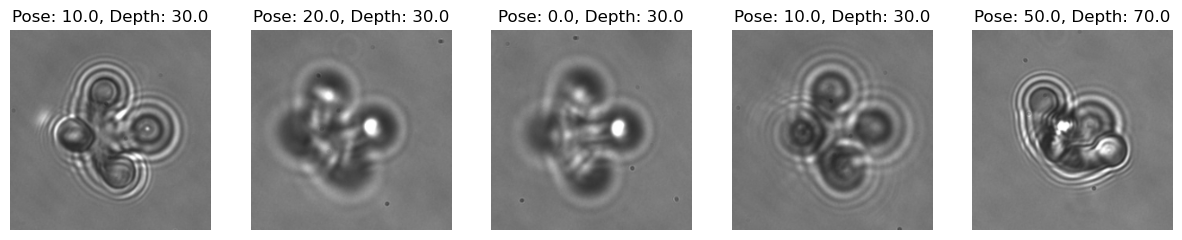

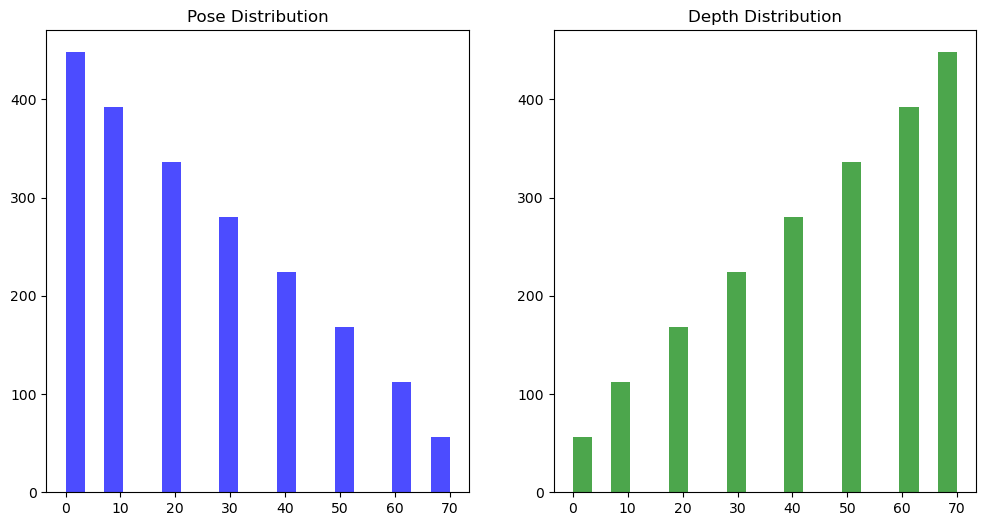

In [22]:
#vidualise a few samples...
def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx])
        plt.title(f"Pose: {labels[idx][0]}, Depth: {labels[idx][1]}")
        plt.axis('off')
    plt.show()

visualize_samples(images, labels)

#plotting labels...
labels_df = pd.DataFrame(labels, columns=["Pose", "Depth"])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(labels_df["Pose"], bins=20, color='blue', alpha=0.7)
plt.title("Pose Distribution")
plt.subplot(1, 2, 2)
plt.hist(labels_df["Depth"], bins=20, color='green', alpha=0.7)
plt.title("Depth Distribution")
plt.show()


In [12]:
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (2016, 224, 224, 3)
Labels shape: (2016, 2)


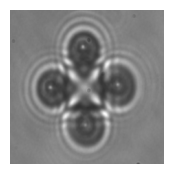

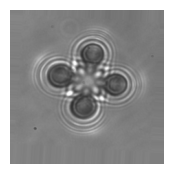

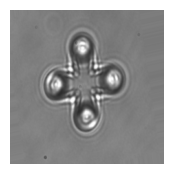

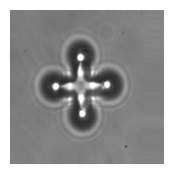

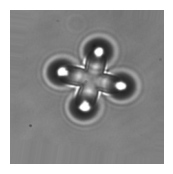

In [23]:
#data augmentation...
augmenter = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

#demo...
augmented_sample = augmenter.flow(images[:5], batch_size=1)
for _ in range(5):
    plt.figure(figsize=(10, 2))
    for img in augmented_sample:
        plt.imshow(img[0])
        plt.axis('off')
        break
    plt.show()


In [ ]:
#normalise
images = images / 255.0
y_labels_combined = labels

#splitting data
X_train, X_test, y_train, y_test = train_test_split(images, y_labels_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

In [14]:
#CNN classification...

def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn((224, 224, 3))



In [15]:
def build_vgg(input_shape):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg_model = build_vgg((224, 224, 3))


In [18]:

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = Add()([x, shortcut])  
    return x

def build_resnet(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


resnet_model = build_resnet((224, 224, 3))


ValueError: Inputs have incompatible shapes. Received shapes (112, 112, 128) and (112, 112, 64)

In [ ]:
#CNN Model...
cnn_model = build_cnn((224, 224, 3))

#VGG Model...
vgg_model = build_vgg((224, 224, 3))

#ResNet Model...
resnet_model = build_resnet((224, 224, 3))


In [ ]:
# Train models
cnn_history = cnn_model.fit(
    augmenter.flow(X_train, y_train[:, :1], batch_size=32),
    validation_data=(X_val, y_val[:, :1]),
    epochs=20,
    callbacks=[checkpoint]
)

vgg_history = vgg_model.fit(
    augmenter.flow(X_train, y_train[:, :1], batch_size=32),
    validation_data=(X_val, y_val[:, :1]),
    epochs=20,
    callbacks=[checkpoint]
)

resnet_history = resnet_model.fit(
    augmenter.flow(X_train, y_train[:, :1], batch_size=32),
    validation_data=(X_val, y_val[:, :1]),
    epochs=20,
    callbacks=[checkpoint]
)


In [ ]:
labels = ["Pose 0", "Pose 1"]
evaluate_classification_model(cnn_model, X_test, y_test[:, :1], labels)
evaluate_classification_model(vgg_model, X_test, y_test[:, :1], labels)
evaluate_classification_model(resnet_model, X_test, y_test[:, :1], labels)


In [19]:
#regression model...
def build_depth_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')  
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

depth_model = build_depth_model((224, 224, 3))


In [ ]:
depth_model = build_depth_model((224, 224, 3))

In [ ]:
depth_history = depth_model.fit(
    augmenter.flow(X_train, y_train[:, 1:], batch_size=32),
    validation_data=(X_val, y_val[:, 1:]),
    epochs=20,
    callbacks=[checkpoint]
)


In [21]:
#training....
# Callbacks for saving the best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_resnet_model.keras', save_best_only=True, monitor='val_accuracy'
)

# Train ResNet model
history_resnet = resnet_model.fit(
    augmenter.flow(X_train, y_train[:, :2], batch_size=32),
    validation_data=(X_val, y_val[:, :2]),
    epochs=25,
    callbacks=[checkpoint]
)

cnn_model.fit(
    augmenter.flow(X_train, y_train[:, :2], batch_size=32),
    validation_data=(X_val, y_val[:, :2]),
    epochs=25,
    callbacks=[checkpoint]
)

vgg_model.fit(
    augmenter.flow(X_train, y_train[:, :2], batch_size=32),
    validation_data=(X_val, y_val[:, :2]),
    epochs=25,
    callbacks=[checkpoint]
)

resnet_model.fit(
    augmenter.flow(X_train, y_train[:, :2], batch_size=32),
    validation_data=(X_val, y_val[:, :2]),
    epochs=25,
    callbacks=[checkpoint]
)

depth_model.fit(
    augmenter.flow(X_train, y_train[:, 1], batch_size=32), 
    validation_data=(X_val, y_val[:, 1]),
    epochs=25,
    callbacks=[checkpoint]
)



NameError: name 'resnet_model' is not defined

In [9]:
#training visualisation...
def plot_training(history):
    if history is None:
        print("No training history available to plot.")
        return
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()


In [14]:
#evalution + visuallisation of regression...
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_classification_model(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=labels))
    
    plot_confusion_matrix(y_true_classes, y_pred_classes, labels)

labels = ["Pose 0", "Pose 1"]
evaluate_classification_model(cnn_model, X_test, y_test[:, :2], labels)
evaluate_classification_model(vgg_model, X_test, y_test[:, :2], labels)
evaluate_classification_model(resnet_model, X_test, y_test[:, :2], labels)


ValueError: in user code:

    File "c:\Users\islas\miniconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\islas\miniconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\islas\miniconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\islas\miniconda3\envs\dl_env\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\islas\miniconda3\envs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\islas\miniconda3\envs\dl_env\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)


In [15]:
from sklearn.metrics import mean_squared_error

def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Depth")
    plt.ylabel("Predicted Depth")
    plt.title("True vs Predicted Depth")
    plt.show()


evaluate_regression_model(depth_model, X_test, y_test[:, 1])  




NameError: name 'depth_model' is not defined

In [ ]:
evaluate_regression_model(depth_model, X_test, y_test[:, 1])

In [16]:
def plot_training_metrics(history, metric, val_metric, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric], label=f'Train {ylabel}')
    plt.plot(history.history[val_metric], label=f'Val {ylabel}')
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def visualize_classification_training(history):
    plot_training_metrics(history, 'accuracy', 'val_accuracy', 'Accuracy Over Epochs', 'Accuracy')
    plot_training_metrics(history, 'loss', 'val_loss', 'Loss Over Epochs', 'Loss')

def visualize_regression_training(history):
    plot_training_metrics(history, 'mae', 'val_mae', 'Mean Absolute Error Over Epochs', 'MAE')
    plot_training_metrics(history, 'loss', 'val_loss', 'Loss Over Epochs', 'Loss')


visualize_classification_training(history_cnn)
visualize_classification_training(history_vgg)
visualize_classification_training(history_resnet)

visualize_regression_training(history_regression)



NameError: name 'history_cnn' is not defined

In [17]:
def evaluate_all_models(cnn_history, vgg_history, resnet_history, regression_history, 
                        cnn_model, vgg_model, resnet_model, depth_model, 
                        X_test, y_test, labels):
    print("\n=== CNN Model Evaluation ===")
    evaluate_classification_model(cnn_model, X_test, y_test[:, :2], labels)
    visualize_classification_training(cnn_history)
    
    print("\n=== VGG Model Evaluation ===")
    evaluate_classification_model(vgg_model, X_test, y_test[:, :2], labels)
    visualize_classification_training(vgg_history)
    
    print("\n=== ResNet Model Evaluation ===")
    evaluate_classification_model(resnet_model, X_test, y_test[:, :2], labels)
    visualize_classification_training(resnet_history)
    
    print("\n=== Depth Estimation Model Evaluation ===")
    evaluate_regression_model(depth_model, X_test, y_test[:, 1])
    visualize_regression_training(regression_history)


evaluate_all_models(
    history_cnn, history_vgg, history_resnet, history_regression,
    cnn_model, vgg_model, resnet_model, depth_model,
    X_test, y_test, labels
)



NameError: name 'history_cnn' is not defined